<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/parkinson/blob/main/conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf ex1ConvertedImages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import SGD,Adam
from torch.utils.data import DataLoader,Dataset, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


In [3]:
try:
  import torchmetrics
  from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix,\
                                BinaryPrecision,BinaryRecall,BinaryROC,BinaryAUROC
except:
  !pip install torchmetrics
  import torchmetrics
  from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix,\
                                BinaryPrecision,BinaryRecall,BinaryROC,BinaryAUROC

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
%%bash
wget -q https://github.com/hikmatfarhat-ndu/parkinson/raw/main/ex1ConvertedImages.zip
unzip -q ex1ConvertedImages.zip

In [5]:
transform = transforms.ToTensor()
dataset=ImageFolder("ex1ConvertedImages",transform=transform)

In [6]:


class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # input is (*,3,512,512)
    self.model=nn.Sequential(
      nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3),

    # input is (*,32,510,510)
      nn.MaxPool2d(kernel_size=(2,2)),
# input is (*,32,255,255)
      nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
      nn.ReLU(),
    # input is (*,64,253,253)
      nn.MaxPool2d(kernel_size=(2,2)),
    # input is (*,64,126,126)
      nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
      nn.ReLU(),
    # input is (*,128,124,124)
      nn.MaxPool2d(kernel_size=(2,2)),
    # input is (*,128,62,62)
      nn.Flatten(),
    # input is (*,128x62x62)
      nn.Linear(in_features=62*62*128,out_features=1)

    )

  def forward(self,x):
    return self.model(x)

In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'


In [8]:

def get_accuracy(dataloader,model):
  accuracy=BinaryAccuracy().to(device)
#   total=len(dataloader)*dataloader.batch_size
#   correct=0
  for imgs,labels in dataloader:
    imgs,labels=imgs.to(device),labels.to(device)
    outputs=model(imgs)
  # torchmetrics BinaryAccuracy automatically applies sigmoid
  # and threshold of (default) 0.5
    accuracy.update(outputs.squeeze(),labels)

  return accuracy.compute().item()

In [9]:
k=10
acc_v=np.empty(k)
auroc_v=np.empty(k)
precision_v=np.empty(k)
recall_v=np.empty(k)
roc_v=[]
conmat_v=[]

In [10]:
for v in range(k):
    accuracy=BinaryAccuracy().to(device)
    conmat=BinaryConfusionMatrix().to(device)
    precision=BinaryPrecision().to(device)
    recall=BinaryRecall().to(device=device)
    roc=BinaryROC().to(device=device)
    auroc=BinaryAUROC().to(device=device)
    print(f'Fold {v}')
    print('---------------------')
    print('---------------------')
    model=Net().to(device)
    optimizer=Adam(model.parameters())
    loss_fn=nn.BCEWithLogitsLoss()
    epochs=30
    dataset_train,dataset_test=random_split(dataset,lengths=[0.8,0.2])
    loader_train=DataLoader(dataset_train,batch_size=32,shuffle=True,num_workers=2)
    loader_test=DataLoader(dataset_test,batch_size=16,shuffle=False)

    for epoch in range(epochs):
      loop=tqdm(loader_train)
      loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
      epoch_loss=0.
      for (imgs,labels) in loop:
        optimizer.zero_grad()
        imgs=imgs.cuda()
        labels=labels.cuda()
        outputs=model(imgs)
        loss=loss_fn(outputs.squeeze(),labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)

      acc=get_accuracy(loader_test,model)
      print(acc)
    for data in loader_test:
      imgs,labels=data
      imgs=imgs.cuda()
      labels=labels.cuda()
      outputs=model(imgs).squeeze()

      accuracy.update(outputs,labels)
      recall.update(outputs,labels)
      roc.update(outputs,labels)
      auroc.update(outputs,labels)
      precision.update(outputs,labels)
      conmat.update(outputs,labels)

    acc_val=accuracy.compute()
    x=conmat.compute().cpu().numpy()
    precision_val=precision.compute()
    recall_val=recall.compute()
    auroc_val=auroc.compute()
    roc_val=roc.compute()
    a=[z.cpu().numpy() for z in roc_val[:2]]
    roc_v.append((roc_val[0].cpu().numpy(),roc_val[1].cpu().numpy()))
    acc_v[v]=acc_val.cpu().numpy()
    auroc_v[v]=auroc_val.cpu().numpy()
    precision_v[v]=precision_val
    recall_v[v]=recall_val
    conmat_v.append(x)
    print(f'accuracy={acc_val} precision={precision_val}, recall={recall_val},auroc={auroc_val}')

Fold 0
---------------------
---------------------


Epoch [1/30]: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s, loss=0.883]


0.375


Epoch [2/30]: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s, loss=0.301]


0.375


Epoch [3/30]: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s, loss=0.295]


0.6875


Epoch [4/30]: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s, loss=0.25]


0.6875


Epoch [5/30]: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s, loss=0.244]


0.375


Epoch [6/30]: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, loss=0.25]


0.6875


Epoch [7/30]: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s, loss=0.208]


0.53125


Epoch [8/30]: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s, loss=0.193]


0.8125


Epoch [9/30]: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s, loss=0.158]


0.71875


Epoch [10/30]: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s, loss=0.161]


0.84375


Epoch [11/30]: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s, loss=0.175]


0.78125


Epoch [12/30]: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s, loss=0.163]


0.75


Epoch [13/30]: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s, loss=0.143]


0.8125


Epoch [14/30]: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=0.175]


0.71875


Epoch [15/30]: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s, loss=0.146]


0.78125


Epoch [16/30]: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s, loss=0.221]


0.625


Epoch [17/30]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, loss=0.23]


0.71875


Epoch [18/30]: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s, loss=0.139]


0.6875


Epoch [19/30]: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s, loss=0.131]


0.71875


Epoch [20/30]: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, loss=0.158]


0.8125


Epoch [21/30]: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s, loss=0.119]


0.8125


Epoch [22/30]: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s, loss=0.111]


0.78125


Epoch [23/30]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s, loss=0.118]


0.71875


Epoch [24/30]: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s, loss=0.139]


0.78125


Epoch [25/30]: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s, loss=0.138]


0.78125


Epoch [26/30]: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s, loss=0.106]


0.8125


Epoch [27/30]: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s, loss=0.119]


0.78125


Epoch [28/30]: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s, loss=0.105]


0.8125


Epoch [29/30]: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s, loss=0.107]


0.8125


Epoch [30/30]: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s, loss=0.112]


0.8125
accuracy=0.8125 precision=0.75, recall=0.75,auroc=0.8625000715255737
Fold 1
---------------------
---------------------


Epoch [1/30]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=0.83]


0.53125


Epoch [2/30]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s, loss=0.295]


0.46875


Epoch [3/30]: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s, loss=0.341]


0.53125


Epoch [4/30]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, loss=0.307]


0.59375


Epoch [5/30]: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s, loss=0.261]


0.59375


Epoch [6/30]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s, loss=0.266]


0.8125


Epoch [7/30]: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=0.225]


0.78125


Epoch [8/30]: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s, loss=0.207]


0.8125


Epoch [9/30]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s, loss=0.233]


0.8125


Epoch [10/30]: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s, loss=0.261]


0.71875


Epoch [11/30]: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s, loss=0.174]


0.84375


Epoch [12/30]: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=0.178]


0.875


Epoch [13/30]: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s, loss=0.167]


0.8125


Epoch [14/30]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=0.23]


0.875


Epoch [15/30]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s, loss=0.178]


0.78125


Epoch [16/30]: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s, loss=0.193]


0.875


Epoch [17/30]: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=0.18]


0.875


Epoch [18/30]: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s, loss=0.149]


0.75


Epoch [19/30]: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s, loss=0.164]


0.78125


Epoch [20/30]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s, loss=0.157]


0.8125


Epoch [21/30]: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s, loss=0.129]


0.875


Epoch [22/30]: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s, loss=0.185]


0.875


Epoch [23/30]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s, loss=0.126]


0.875


Epoch [24/30]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s, loss=0.168]


0.8125


Epoch [25/30]: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, loss=0.121]


0.875


Epoch [26/30]: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, loss=0.147]


0.8125


Epoch [27/30]: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s, loss=0.163]


0.84375


Epoch [28/30]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=0.152]


0.875


Epoch [29/30]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=0.13]


0.8125


Epoch [30/30]: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s, loss=0.157]


0.78125
accuracy=0.78125 precision=0.7222222089767456, recall=0.8666666746139526,auroc=0.9372549057006836
Fold 2
---------------------
---------------------


Epoch [1/30]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s, loss=0.714]


0.53125


Epoch [2/30]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, loss=0.301]


0.53125


Epoch [3/30]: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, loss=0.306]


0.71875


Epoch [4/30]: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s, loss=0.295]


0.71875


Epoch [5/30]: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, loss=0.256]


0.78125


Epoch [6/30]: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s, loss=0.24]


0.71875


Epoch [7/30]: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s, loss=0.212]


0.8125


Epoch [8/30]: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, loss=0.205]


0.84375


Epoch [9/30]: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s, loss=0.145]


0.84375


Epoch [10/30]: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s, loss=0.142]


0.84375


Epoch [11/30]: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, loss=0.19]


0.8125


Epoch [12/30]: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s, loss=0.173]


0.84375


Epoch [13/30]: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, loss=0.178]


0.875


Epoch [14/30]: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, loss=0.146]


0.84375


Epoch [15/30]: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s, loss=0.135]


0.84375


Epoch [16/30]: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, loss=0.137]


0.84375


Epoch [17/30]: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s, loss=0.122]


0.875


Epoch [18/30]: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s, loss=0.241]


0.5


Epoch [19/30]: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s, loss=0.206]


0.71875


Epoch [20/30]: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, loss=0.258]


0.78125


Epoch [21/30]: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s, loss=0.162]


0.875


Epoch [22/30]: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s, loss=0.125]


0.875


Epoch [23/30]: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s, loss=0.126]


0.8125


Epoch [24/30]: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s, loss=0.118]


0.875


Epoch [25/30]: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, loss=0.145]


0.8125


Epoch [26/30]: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s, loss=0.18]


0.8125


Epoch [27/30]: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s, loss=0.141]


0.84375


Epoch [28/30]: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s, loss=0.118]


0.875


Epoch [29/30]: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s, loss=0.101]


0.875


Epoch [30/30]: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s, loss=0.181]


0.75
accuracy=0.75 precision=0.7058823704719543, recall=0.800000011920929,auroc=0.8823529481887817


In [11]:
print(f'accuracy_mean={acc_v.mean()}')
print(f'precision_mean={precision_v.mean()}')
print(f'recall_mean={recall_v.mean()}')
print(f'auroc_mean={auroc_v.mean()}')
tpr=roc_v[0][0]
fpr=roc_v[0][1]
for i in range(1,k):
  tpr+=roc_v[i][0]
  fpr+=roc_v[i][1]
tpr/=k
fpr/=k

#mat=np.empty((2,2))
mat=conmat_v[0]
for i in range(1,k):
  mat+=conmat_v[i]
mat=mat/k

accuracy_mean=0.78125
precision_mean=0.7260348598162333
recall_mean=0.8055555621782938
auroc_mean=0.8940359751383463


In [12]:
print(mat)

[[13.66666667  4.33333333]
 [ 2.66666667 11.33333333]]


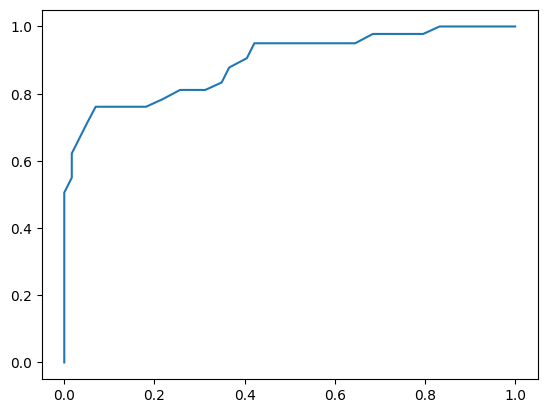

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tpr,fpr)